[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aarondomenzain/tracking-softmatter-aarond/blob/tracking-softmatter-aarond-dev/tutorial/detection/detection_spheres.ipynb)

# Particle Tracking Tutorial: Particle Detection and Localization
In this tutorial, you’ll explore different methods to detect and localize particles in microscopy images — using both simulated data and real experimental images.

You’ll start by generating a simulated image of microscopic particles, mimicking what you might see in a soft matter or biophysics experiment. Since you know the true particle positions in the simulation (i.e., the 'ground truth'), you can directly evaluate how well each detection method performs.

Here’s what you’ll test and compare:

- Thresholding and Connected Components

- Crocker and Grier (using trackpy — a classic in particle tracking)

- U-Net (a neural network for image segmentation)

- LodeSTAR (an unsupervised deep learning method)

You’ll be using Python libraries like NumPy, SciPy, Matplotlib, scikit-image, PyTorch, DeepTrack, and Deeplay. 

## Table of Contents

0. [Import the Required Libraries and Load Utility Functions](#import-the-required-libraries-and-load-utility-functions)
1. [Load and Visualize Experimental Images](#load-and-visualize-experimental-images)
2. [Simulate Realistic Images with DeepTrack](#simulate-realistic-images-with-deeptrack)
    - [Simulate a Single Particle](#simulate-a-single-particle)
    - [Simulate a Test Image to Benchmark Detection Methods](#simulate-a-test-image-to-benchmark-detection-methods)
3. [Method 1: Thresholding and Connected Components](#3-method-1-thresholding-and-connected-components)
    - [Apply Intensity Thresholding](#apply-intensity-thresholding)
    - [Determine Centroids with Connected Components Analysis](#determine-centroids-with-connected-components-analysis)
    - [Evaluate the Performance of the Method](#evaluate-the-performance-of-the-method)
      - [Refine Localization](#refine-localization)
    - [Apply the Method to Experiments](#apply-the-method-to-experiments)

4. [Method 2: Crocker and Grier](#method-2-crocker-and-grier)
    - [Estimate Particle Size from Simulations](#estimate-particle-size-from-simulations)
    - [Apply the Crocker and Grier Method to Simulations](#apply-the-crocker-and-grier-method-to-simulations)
    - [Apply the Crocker and Grier Method to Experiments](#apply-the-crocker-and-grier-method-to-experiments)

5. [Method 3: U-Net](#method-3-u-net)
    - [Create a Training Dataset](#create-a-training-dataset)
    - [Define a U-Net Model with Deeplay](#define-a-u-net-model-with-deeplay)
    - [Train the U-Net model](#train-the-u-net-model)
    - [Apply the Trained U-Net to the Simulations](#apply-the-trained-u-net-to-simulations)
    - [Apply the Trained U-Net to the Experiments](#apply-the-trained-u-net-to-experiments)

6. [Method 4: LodeSTAR](#method-4-lodestar)
    - [Simulate Training Data for LodeSTAR](#simulate-training-data-for-lodestar)
    - [Train LodeSTAR and Apply it to Simulations](#train-lodestar-and-apply-it-to-simulations)
    - [Apply the Trained LodeSTAR to Experiments](#apply-the-trained-lodestar-to-experiments)
    - [Train LodeSTAR with Experiments](#train-lodestar-with-experimentas)

## Import the Required Libraries and Load Utility Functions

Uncomment the next cell if running on Google Colab/Kaggle.

In [ ]:
#!pip install deeptrack deeplay trackpy -q

Import required libraries.

In [ ]:
# Standard libraries.
import os
import random
import sys

# Core Scientific Stack
import numpy as np
import scipy

# Plotting and Display
import matplotlib
import matplotlib.pyplot as plt

# Machine Learning
import torch
import deeplay as dl

# Particle Tracking and Simulation
import deeptrack as dt
import trackpy as tp

# Image Analysis
import imageio  # Creates images/video from data.
import skimage  # Image analysis (scikit).

Load a set of custom functions defined specifically for this notebook from the `utils_detection.py` file. For detailed documentation of each function, refer to the comments and docstrings within `utils_detection.py`.

In [ ]:
# Load functions and utilities for dataset generation and visualization.
# Sys append a folder to the path.
sys.path.append(os.path.abspath(os.path.join("..", "..", "utils")))

# Import all the functions contained in the file utils/utils_detection.py.
import utils_detection as utils

Set random seeds to make results reproducible across runs, especially during training and data simulation.

In [ ]:
# Set a fixed seed value
seed = 89

# Python, NumPy, and PyTorch (CPU)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Only set CUDA seeds if a GPU is available
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Seeds set to {seed} (with CUDA: {torch.cuda.is_available()})")

## Load and Visualize Experimental Images

Load a `.tif` image from the `images/` folder and display it using scikit-image.

In [ ]:
# Define the folder and image file name.
image_folder = "images"
image_file_name = "JT008_AFM_15.tif"

# Construct the full path.
image_path = os.path.join(image_folder, image_file_name)

# Create an instance of the loaded file using SciKit.
image = skimage.io.imread(image_path)

# Crop the image to a square.
image = image[:640, :640]

# Print the name of the selected file.
print("Selected file:", image_path)

# Open a figure instance.
plt.figure()

# Plot the image in grayscale.
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Experimental Image")
plt.tight_layout()
plt.show()

# Print the image size in pixels.
print(f"Size of imported image in pixels: {image.shape}")

Manually select and display a single particle by specifying its centroid coordinates (x,y) and a box width.

**Note:** Images in NumPy are indexed as `(row, column)`, which corresponds to (y, x) in Cartesian coordinates.

In [ ]:
# Box size to zoom in an individual particle.
width = 28

# Coordinates of the center of the particle.
x_center = 212
y_center = 329

# Calculate top-left corner of the crop.
x = x_center - width // 2
y = y_center - width // 2

# Select a crop as a subset of the entire image.
crop = image[y:y + width, x:x + width]  # row (y), column (x)

# Initialize figure instance.
fig = plt.figure()

# Draw a red rectangle around the crop.
fig.add_subplot(111)
plt.imshow(image, cmap='gray')
plt.title("Experimental Image", size=13)
plt.plot([x, x, x+width, x+width, x],[y, y+width, y+width, y, y], 'r-')
plt.axis('off')

# Plot the rectangle on the top right corner.
fig.add_subplot(555)
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.show()

## Simulate Realistic Images with DeepTrack

DeepTrack allows you to simulate physically realistic microscopy images, enabling precise control over imaging parameters and particle properties. These simulations provide ground-truth data, making them ideal for benchmarking classical and AI-based tracking methods, as well as for training neural networks in a controlled environment.

### Simulate a Single Particle

Adjust the simulation parameters to accurately replicate the features observed in the cropped region of the experimental image.

**Note:** While the experimental image was acquired using a non-optical technique (Atomic Force Microscopy), DeepTrack is versatile enough to simulate such images as well. However, in this case, imaging parameters have not physical meaning and can have unrealistic values. 

In [ ]:
# Same as the box width.
image_size = width  

# Size of a pixel in nanometers in the output image.
pixel_size_nm = 100 # In nm.

# Radius of the particle.
particle_radius = 950 # In nm.

# Define central spherical scatterer.
sphere = dt.Sphere(
    position=0.5 * np.array([image_size, image_size]),
    z=0 * dt.units.nm, # Particle in focus.
    radius=particle_radius * dt.units.nm,  # Radius in nanometers.
    intensity=7.5E4,  # Field magnitude squared.
)

# Simulate the properties of the fluorescence microscope.
optics = dt.Fluorescence(
    NA=0.7,  # Numerical aperture.
    wavelength=590 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size_nm * dt.units.nm, # Camera resolution or effective resolution.
)

# Apply transformations.
sim_crop = (
    optics(sphere) 
    >> dt.Background(2500)
)
# Turn the crop into a NumPy array.
simulated_crop = np.squeeze(sim_crop())

# Plot the simulated and experimental crops.
fig, axes = plt.subplots(1, 2)

# Simulated crop.
plot = axes[0].imshow(simulated_crop, cmap="gray")
axes[0].axis("off")
axes[0].set_title("Simulated Crop")

# Experimental crop.
axes[1].imshow(crop, cmap="gray")  
axes[1].axis("off")
axes[1].set_title("Experimental Crop")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()

Extract and visualize the raw intensity profiles along the central horizontal and vertical lines of both the simulated and experimental crops. This comparison helps evaluate how well the simulation reproduces the intensity distribution observed in real microscopy images.

In [ ]:
# Compute the center index.
center = image_size // 2

# Extract horizontal (row) profiles.
sim_horiz = simulated_crop[center, :]
exp_horiz = crop[center, :]

# Extract vertical (column) profiles.
sim_vert = simulated_crop[:, center]
exp_vert = crop[:, center]

# Create a 1×2 subplot.
fig, axes = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

# --- Horizontal profile ---
axes[0].plot(sim_horiz, label="Simulated Crop", color="orange")
axes[0].plot(exp_horiz, label="Experimental Crop", color="blue")
axes[0].set_xlabel("Pixel (x)")
axes[0].set_ylabel("Intensity")
axes[0].set_title("Horizontal Intensity Profile (Center Row)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Vertical profile ---
axes[1].plot(sim_vert, label="Simulated Crop", color="orange")
axes[1].plot(exp_vert, label="Experimental Crop", color="blue")
axes[1].set_xlabel("Pixel (y)")
axes[1].set_ylabel("Intensity")
axes[1].set_title("Vertical Intensity Profile (Center Column)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)


### Simulate a Test Image to Benchmark Detection Methods

Create a simulated image containing non-overlapping spherical particles. Begin by generating their coordinates—these will serve as the ground-truth positions. Then, use DeepTrack to render optically realistic particles at these coordinates, resulting in a physically plausible microscopy image.

In [ ]:
# Parameters of the simulation.
image_size = 512
N_particles = 1200
particle_radius = 950  # Particle radius in nm.

# Dictionary for particle properties. Dimensions are set with lambda
# functions to introduce variety to the dataset.
sphere_properties = {
    "radius": lambda: np.random.uniform(0.9, 1.0) * particle_radius * dt.units.nm,
    "intensity": lambda: np.random.normal(1.1, 0.1) * 7.5E4,
    "z": 0 * dt.units.nm,
}

# Set the optical properties of the microscope.  
optics_properties = dt.Fluorescence(
    NA=0.7,  # Numerical aperture.
    wavelength=590 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size_nm * dt.units.nm, # Camera resolution or effective resolution.
)

# Generate ground truth positions.
gt_pos = utils.generate_centroids(
    num_particles=N_particles,
    image_size=image_size,
    particle_radius=particle_radius, 
)

# Simulate image.
simulated_image = utils.transform_to_video(
    gt_pos,
    image_size=image_size,
    core_particle_props=sphere_properties,
    optics_props=optics_properties,
    background_props={"poisson_snr": 8900, "background_mean": 2500},
)

# Generate the ground truth as Gaussian clouds centered at the position of the
# spheres. The standard deviation of the Gaussians are set to be proportional 
# to the radii of the corresponding spherical particles.
ground_truth_cloud_size = particle_radius / 3

# Generate ground truth map using the positions, radii and intensities of the 
# particles.
simulated_map = utils.create_ground_truth_map(
    gt_pos, 
    image_size=image_size, 
    sigma=ground_truth_cloud_size, 
)

Visualize the simulated image and compare it with the experimental one.

In [ ]:
# Plot the simulated and experimental images.
fig, axes = plt.subplots(1, 2)

# Simulated image.
plot = axes[0].imshow(simulated_image, cmap="gray")
axes[0].axis("off")
axes[0].set_title("Simulated Image")

# Experimental image.
axes[1].imshow(image, cmap="gray")  
axes[1].axis("off")
axes[1].set_title("Experimental Image")

# Adjust layout and show plot.
plt.tight_layout()
plt.show()

Perform a more quantitative comparison by plotting the intensity histograms.

**Note:** The simulated image has less spherical particles and a larger variability in their intensity as compared to the experimental one. These differences are visible in the histogram but the dynamic range and the overall shape of the distribution of intensity are rather similar.

In [ ]:
# Flatten the arrays to 1D.
sim_vals = simulated_image.ravel()
exp_vals = image.ravel()

# Create figure with two subplots sharing the y-axis.
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True, tight_layout=True)

# Histogram for simulated image.
axes[0].hist(sim_vals, bins=80, alpha=0.7, edgecolor="black", density=True)
axes[0].set_title("Simulated Image Histogram")
axes[0].set_xlabel("Normalized Intensity")
axes[0].set_ylabel("Probability Density")

# Histogram for experimental image.
axes[1].hist(exp_vals, bins=80,  alpha=0.7, edgecolor="black", density=True)
axes[1].set_title("Experimental Image Histogram")
axes[1].set_xlabel("Normalized Intensity")
# No need to set ylabel on the second axes when sharing.

plt.show()

Visualize the simulated image and the corresponding ground truth map. Each particle has an associated ground truth cloud with a Gaussian profile, whose standard deviation is proportional to the radius of the particle.

In [ ]:
# Create a subfigure instance to plot the image and the probability map.
fig, ax = plt.subplots(1, 2)

# Instance for the simulated experimental image. 
img1 = ax[0].imshow(simulated_image, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Simulated Image")  

# Instance for the probability map.
img2 = ax[1].imshow(simulated_map, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Simulated Probability Map (Gaussian)") 

# Adjust layout to avoid overlap.
plt.tight_layout()

# Show the plot.
plt.show()

From now on, you'll use normalized images.

In [ ]:
# Normalize the images to the range [0, 1].
image = utils.normalize_min_max(image)
simulated_image = utils.normalize_min_max(simulated_image)

## Method 1: Thresholding and Connected Components

In a grayscale image, each pixel has an intensity value, where higher values typically correspond to stronger signals—often indicating the presence of particles—while lower values represent the background.

A simple and effective method for particle detection is **intensity thresholding**, which converts the grayscale image into a binary mask. Pixels with intensities above a chosen threshold are marked as foreground (set to 1), and the rest as background (set to 0).

If particles appear darker than the background—as in absorption-based or negative stain imaging—the threshold should instead be applied to the lower end of the intensity distribution.

After thresholding, **connected component analysis** can be used to label and isolate individual foreground regions. Each connected component represents a candidate particle, enabling basic localization by computing properties such as the centroid (position), area (size), or bounding box (extent) of each region.

### Apply Intensity Thresholding 

A robust way to choose the threshold is to use the **intensity quantile**. For example, setting the threshold at the 90th percentile selects the brightest 10% of pixels, which often correspond to particles. This method is more reliable than using the image mean and standard deviation, which can be biased by background-dominated images.

Before thresholding, it’s a good idea to smooth the image with a Gaussian filter. This helps suppress noise and small fluctuations that aren’t real particles.

In [ ]:
# Apply a Gaussian filter to the image to smooth out noise.
filtered_simulated_image = scipy.ndimage.gaussian_filter(simulated_image, sigma=1.0)

# Flatten the filtered image for thresholding.
flattened_filtered_simulated_image = filtered_simulated_image.flatten()

# Define the quantile level (e.g., 90% selects the top 10% brightest pixels).
quantile_level = 0.85

# Compute the threshold as the intensity value at the given quantile.
intensity_threshold = np.quantile(flattened_filtered_simulated_image, quantile_level)

print(f"Intensity threshold (quantile={quantile_level*100:.0f}%): {intensity_threshold}")

Plot the intensity histogram of the simulated image before and after Gaussian filtering.

In [ ]:
# Flatten the normalized image for thresholding.
flattened_simulated_image = simulated_image.flatten()

# Compute statistics
median_intensity_simulated = np.median(flattened_simulated_image)
quantile_threshold_simulated = np.quantile(flattened_simulated_image, quantile_level)

median_intensity_filtered_simulated = np.median(flattened_filtered_simulated_image)
quantile_threshold_filtered_simulated = np.quantile(flattened_filtered_simulated_image, quantile_level)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Histogram for simulated image
axes[0].hist(flattened_simulated_image, bins=128, range=(0, 1), color='gray', alpha=0.75, density=True)
axes[0].axvline(median_intensity_simulated, color='red', linestyle='dashed', linewidth=1.5, label="Median")
axes[0].axvline(quantile_threshold_simulated, color='green', linestyle='dashed', linewidth=1.5, label=f"{int(quantile_level*100)}th Percentile")
axes[0].set_title("Simulated Image", fontsize=14)
axes[0].set_yticklabels([])  # Remove y labels
axes[0].legend()
axes[0].grid(True)

# Histogram for filtered image
axes[1].hist(flattened_filtered_simulated_image, bins=128, range=(0, 1), color='gray', alpha=0.75)
axes[1].axvline(median_intensity_filtered_simulated, color='red', linestyle='dashed', linewidth=1.5, label="Median")
axes[1].axvline(quantile_threshold_filtered_simulated, color='green', linestyle='dashed', linewidth=1.5, label=f"{int(quantile_level*100)}th Percentile")
axes[1].set_title("Simulated Image + Gaussian Filter", fontsize=14)
axes[1].set_yticklabels([])
axes[1].legend()
axes[1].grid(True)

# Set common x and y labels
fig.supxlabel("Normalized Intensity", fontsize=12)
fig.supylabel("Normalized Frequency [counts]", fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

Apply the threshold to generate a binary mask, then display it together with the original image for visual validation.

In [ ]:
# Create the binary mask by applying the threshold.
simulated_mask = filtered_simulated_image > intensity_threshold

# Ensure the mask is a 2D array.
simulated_mask = np.squeeze(simulated_mask)

# Plot the image with the calculated mask.
utils.plot_image_mask_ground_truth_map(
    image=simulated_image, 
    mask=simulated_mask, 
    title="Mask with Intensity Thresholding",
)

### Determine Centroids with Connected Components Analysis

Detect objects from the binary mask and extract their centroids using the scikit-image library. This is typically done by identifying connected components and computing their center of mass, which provides an estimate of each particle’s position.

In [ ]:
# Use the function to extract positions from mask.
detections_M1 = utils.mask_to_positions(simulated_mask)
print(f"Found {len(detections_M1[:,1])} detections.")

Plot the extracted centroids on top of the image.

In [ ]:
# Use the plotting function to compare the detection with the ground truth.
utils.plot_predicted_positions(
    image=simulated_image, 
    predicted_positions=detections_M1, 
    ground_truth_positions=gt_pos, 
    title="Method 1 - Simulated Image",
)

### Evaluate the Performance of the Method

Apply the `evaluate_locs` function that calculates evaluation metrics and print them. It calculates True Positives (TP), False Positives (FP), False Negatives (FN), F1 score (F1) and Mean Square Error (MSE).

In [ ]:
# Evaluation metrics can be retrieved if returned outputs are asigned to a variable:
# TP, FP, FN, F1, RMSE = utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius).

utils.evaluate_locs(detections_M1, gt_pos, distance_th=particle_radius);

#### Refine Localization

You can imporve localization precision by passing the raw image into `mask_to_positions`. This function uses the actual gray‐level intensities within each connected component to compute a weighted centroid, giving you subpixel‐refined coordinates.

Use weighted centroid refinement to achieve more accurate centroid positions.

In [ ]:
# Estimate the location of the centroid of a masked particle image.
detections_M1_ref = utils.mask_to_positions(simulated_mask, simulated_image.squeeze())

# Evaluate the performance.
utils.evaluate_locs(detections_M1_ref, gt_pos, distance_th=particle_radius);

### Apply the Method to Experiments

Apply the same method to the experimental image:

- Smooth the image using a Gaussian filter.
- Choose a threshold.
- Create a binary mask where pixels above the threshold are marked as potential particles.
- Extract initial positions from the mask.
- Plot both the predicted positions and the mask for visual inspection.
- Print the number of detections found.

This gives us a first estimate of particle positions using just thresholding—no machine learning needed!

In [ ]:
# Apply a Gaussian filter to the image to smooth out noise.
filtered_image_exp = scipy.ndimage.gaussian_filter(image, sigma=1)

# quantile level for thresholding.
quantile_level = 0.85

# Intensity threshold for the experimental image.
quantile_threshold_exp = np.quantile(filtered_image_exp, quantile_level)

# Create the binary mask by applying the threshold.
mask_exp = filtered_image_exp > quantile_threshold_exp

# Get predicted positions from the mask.
detections_M1_exp = utils.mask_to_positions(mask_exp, image)

# Plot the experimental image with the predicted positions.
utils.plot_predicted_positions(
    image=image,
    predicted_positions=detections_M1_exp,
    title="Method 1 - Experimental Image",
)

# Plot the experimental image and the mask.
utils.plot_image_mask_ground_truth_map(
    image=image, 
    mask=mask_exp, 
    title="Method 1 - Experimental Image",
)

# Print the number of detections.
print(f"Found {len(detections_M1_exp[:,1])} detections.")

## Method 2: Crocker and Grier

A refined approach for particle detection and localization is the Crocker and Grier method. This method identifies local intensity maxima and refines their positions by fitting the surrounding region to a Gaussian-like profile. It offers subpixel accuracy and performs well even in moderately noisy conditions or crowded images.

Trackpy provides a built-in implementation of the Crocker and Grier particle detection method.

### Estimate Particle Size from Simulations

In the trackpy implementation of the Crocker and Grier method, the primary parameter you need to set is the estimated particle size, which must be an odd number.

To estimate this value, inspect the simulated image interactively: click on both edges of a representative particle to measure its approximate width. Keep in mind that particle sizes may vary across the image, so this should be treated as an initial guess. You can refine the diameter later by evaluating the quality of the detections.

In [ ]:
# Set the matplotlib interactive backend .
%matplotlib widget
utils.interactive_ruler(simulated_image)

### Apply the Crocker and Grier Method to Simulations

Use `trackpy.locate` to detect particles in the image. This function returns a DataFrame containing the coordinates of the detected particles along with various feature properties.

Extract the (x, y) positions from the DataFrame and compare them to the ground truth coordinates to assess the accuracy of the detection.

In [ ]:
# Estimate and tune the diameter of particles in pixels, ensuring it is an
# odd number. Adjust if necessary.
estimated_size = 15

# Use the locate built-in function from TrackPy.
# Output is type DataFrame([x, y, mass, size, ecc, signal, raw_mass]).
localizations_dataframe = tp.locate(
    simulated_image, 
    diameter=estimated_size,
    noise_size=3, # Setting for denoising image.
)

# Extract the predicted positions from DataFrame["x","y"] into a NumPy array.
detections_M2 = np.array(localizations_dataframe)[:,:2]

# Plot the prediction and the ground truth.
utils.plot_predicted_positions(
    image=simulated_image,
    predicted_positions=detections_M2,
    ground_truth_positions=gt_pos,
    title="Method 2 - Simulated Image",
)

# Evaluate the performance of tp.locate.
utils.evaluate_locs(
    detections_M2,
    gt_pos,
    distance_th=particle_radius,
);

### Apply the Crocker and Grier Method to Experiments

Interactively estimate particle size.

In [ ]:
# Set the matplotlib interactive backend .
%matplotlib widget
utils.interactive_ruler(image)

Detect particles in the image and display the results.

In [ ]:
# Adjust the estimated diameter if necessary. 
estimated_size = 15

# Use Trackpy.locate to experimental data file 'image'.
localizations_dataframe_exp = tp.locate(
    image, 
    diameter=estimated_size,
    noise_size=3, # Setting for denoising image.
)

# Extract the predicted positions from DataFrame["x","y"] into a NumPy array.
detections_M2_exp = np.array(localizations_dataframe_exp)[:,:2]

# Plot the experimental image with predicted positions overlaid.
utils.plot_predicted_positions(
    image=image,
    predicted_positions=detections_M2_exp,
    title="Method 2 - Experimental Image",
)

print(f"Found {len(detections_M2_exp[:,1])} detections.")

## Method 3: U-Net

U-Net is a convolutional neural network (CNN) widely used for image segmentation tasks. It performs pixel-wise classification, enabling precise separation between background and objects of interest—ranging from simple particles to complex cells or anatomical structures, depending on the training data.

In the context of particle detection, U-Net can be trained to map input microscopy images directly into **probability distributions** that represent the likelihood of a particle being present at each pixel. Instead of assigning a hard classification (particle or background), the network outputs a **dense probability map**—a soft, continuous prediction indicating how likely each pixel is to belong to a particle. This approach is particularly useful in challenging scenarios, such as overlapping particles—where discrete detection may fail—or small, faint particles that traditional methods might miss.

Once trained, U-Net generalizes to new images, producing smooth probability maps that can be thresholded to create binary masks for downstream connected-component analysis. For localization, these maps enable the calculation of **intensity-weighted centroids**, allowing subpixel resolution of particle positions and improving localization accuracy. Alternatively, the maps can be analyzed using peak detection algorithms or interpreted as confidence scores to filter or rank detections.

### Create a training dataset

U-Net is trained using pairs of input images and corresponding target maps, which represent the expected output distribution. These target maps typically consist of Gaussian blobs centered at the true particle locations, encoding both position and uncertainty.

To generate training data, you can simulate particle images using DeepTrack, along with their associated probability maps to serve as ground truth.

If a dataset has already been generated and saved, you can simply load it and skip the simulation step.

In [ ]:
# Number of samples, image size, and particles.
num_samples = 128
image_size = 64
max_num_particles = 10
force_simulation = True  # Flag to force simulation even if data exists.

optics_properties = dt.Fluorescence(
    NA=0.7,  # Numerical aperture.
    wavelength=590 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size_nm * dt.units.nm, # Camera resolution or effective resolution.
)

# Create path to store training dataset.
folder_name = "UNet"
training_dataset_filename = "UNet_training_dataset_spheres.npz"
training_dataset_folder = os.path.join(folder_name, "training_data")
training_dataset_filepath = os.path.join(
    training_dataset_folder, 
    training_dataset_filename,
)

# Create the enclosing directory if not existent already.
if not os.path.exists(training_dataset_folder):
    os.makedirs(training_dataset_folder, exist_ok=True)

# Try to load preexisting data, if not available or forced, raise the
# exception error to generate new data.
try:
    if force_simulation: 
        # Raise the exception error if simulation is forced.
        raise FileNotFoundError("Forced simulation by user request.")
    
    if not os.path.isfile(training_dataset_filepath):
        # If file is not found, start training.    
        raise FileNotFoundError(
            "Training dataset file not found. Starting simulation."
        )
    
    # Load existing data
    data = np.load(training_dataset_filepath)
    images = data['images']
    print(images.shape)
    maps = data['maps']
    Nsamples = len(images)
    print(f"Loaded file: {training_dataset_filepath}")
        
# Handle the case of either file not found or forced training.
except FileNotFoundError:
    # Generate new dataset if file not found or simulation is forced
    images, maps = utils.generate_particle_dataset(
        num_samples = num_samples,
        image_size = image_size,
        max_num_particles = max_num_particles,
        core_particle_dict=sphere_properties,
        optics_properties=optics_properties,
        background_props={"poisson_snr": 8900, "background_mean": 2500},
    )
    
    # Save the simulated training dataset.
    np.savez(training_dataset_filepath, images=images, maps=maps)
    print(f"Training dataset saved in: {training_dataset_filepath}.")

Before training the U-Net model with Deeplay, ensure that the input dataset has the shape (N, X, Y, C), where:

N: Number of samples (simulated images)\
X: Width of the image (pixels along the horizontal axis)\
Y: Height of the image (pixels along the vertical axis)\
C: Number of channels (use 1 for grayscale images)

In [ ]:
print(f"Image dimensions: {images.shape}")
print(f"Maps dimensions: {maps.shape}")

Visualize the simulated training dataset.

In [ ]:
# Select an image and its corresponding probability maps and mask to show.
selected_image_index = np.random.randint(0, len(images))

# Extract the image and probability map from 4D arrays.
selected_image = np.squeeze(images[selected_image_index])
simulated_probability_map = np.squeeze(maps[selected_image_index])

# Plot the image as the first subplot.
utils.plot_image_mask_ground_truth_map(
    image=selected_image,
    ground_truth_map=simulated_probability_map,
    title=f"Training dataset element: {selected_image_index + 1}/{len(images)}",
)

### Define a U-Net model using Deeplay

The name _U-Net_ comes from its characteristic U-shaped architecture, which features a symmetric encoder–decoder structure. The encoder (downsampling path) captures contextual information by progressively reducing spatial resolution, while the decoder (upsampling path) restores spatial detail. Skip connections between corresponding levels of the encoder and decoder help retain fine-grained features, improving segmentation accuracy—especially for small or faint objects.

You'll define a 2D U-Net where both the input and output images have a single channel, corresponding to grayscale intensity. The goal is for the model to learn a mapping from the experimental image to a spatial probability density map that indicates the likelihood of particle presence at each pixel.

The U-Net should be deep enough to extract meaningful features from the input. As a rule of thumb, with a kernel size of 3×3, a network with N convolutional layers has a receptive field of approximately (3×3)^N. For example, using three layers yields a receptive field of 27×27 pixels.

In [ ]:
# Input and output channels are set to 1, since both images and probability
# maps only have one color channel.
unet = dl.UNet2d(
    in_channels=1, 
    channels=[16, 32, 64], 
    out_channels=1,
)

Compile the model for the task of regressing the masks from the images.

In [ ]:
# A U-Net regressor is defined using a deeplay model. The loss function is Mean
# Squared Error Loss, since the output is a continuous intensity map.
unet_reg = dl.Regressor(
    model=unet, 
    loss=torch.nn.MSELoss(), 
    optimizer=dl.Adam(lr=1e-3),
).create()

Define the training pipeline using Deeptrack to generate the training dataset
The training pipeline is composed of the simulated images and the probability maps, together with instructions of value normalization and a selector of images, all of which are instances of Deeplay.

In [ ]:
# Image selector with a random picker. This is performed in order to properly 
# link an element in maps array with its corresponding element in images 
# array.
selector = dt.Lambda(
    lambda i: lambda x: x[i], i=lambda l: np.random.randint(l), l=len(images)
)

# Apply augmentations of added Gaussian noise only to images.
images_augmentations = (
    dt.Value(images)
    >> dt.NormalizeMinMax(0.0, 1.0)
    >> dt.Gaussian(0.0, 0.05)
    >> dt.NormalizeMinMax(
        lambda: np.random.uniform(0.0, 0.1), 
        lambda: np.random.uniform(0.9, 1.0),
    )
)

# Apply normalization to ground truth map.
maps = dt.Value(maps) >> dt.NormalizeMinMax(0.0, 1.0)

# Training pipeline consists of two paired lists: images and maps. 
# Images are augmented and normalized, while maps are only normalized.
# The selector randomly selects an image and its corresponding ground truth map.
# The pipeline is then passed to the deeplay model.
pipeline = (images_augmentations & maps) >> selector

# Create the training dataset instance in PyTorch
train_dataset = dt.pytorch.Dataset(pipeline, length=256)

Randomly select and display one augmented crop from the training dataset. 

In [ ]:
# Sanity check
sanity_check_pipeline_augmentation = np.squeeze(pipeline.update().resolve())
sanity_check_image_augmentation = sanity_check_pipeline_augmentation[0]
sanity_check_map_augmentation = sanity_check_pipeline_augmentation[1]

# # Plot the image as the first subplot
utils.plot_image_mask_ground_truth_map(
    image=sanity_check_image_augmentation,
    ground_truth_map=sanity_check_map_augmentation,
    title=f"Random Augmentation from Training Pipeline",
)

### Train the U-Net model

Create a dataloader to iterate over the training dataset in batches ensuring randomized sampling at each epoch. Initialize a Trainer from Deeplay to train the U-Net model for up to 64 epochs.

In [ ]:
from torch.utils.data import DataLoader

# Create a DataLoader for training.
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True,
)

# Initialize UNet trainer with automatic accelerator (e.g., CUDA if available).
unet_trainer = dl.Trainer(max_epochs=64, accelerator="auto")

Attempt to load pre-trained weights for the U-Net model. If the weights file does not exist, train the model from scratch and save the weights for future use.

In [ ]:
# Force training if desired.
force_training = True

# Define the file paths for the model weights.
unet_path = "UNet_model_spheres.pth"
unet_reg_path = "UNet_reg_spheres.pth"

# Define folder and construct full file paths.
folder_name = "UNet"
unet_path = os.path.join(folder_name, unet_path)
unet_reg_path = os.path.join(folder_name, unet_reg_path)

# Load preexisting weights if they exist and training is not forced.
if not force_training and os.path.exists(unet_path) and os.path.exists(unet_reg_path):
    unet.load_state_dict(torch.load(unet_path, weights_only=True))
    unet_reg.load_state_dict(torch.load(unet_reg_path, weights_only=True))
    print(f"Loaded preexisting U-Net weights from '{folder_name}/'.")
else:
    print("Training U-Net model (either forced or weights not found).")
    
    # Ensure the save directory exists.
    os.makedirs(folder_name, exist_ok=True)

    # Train the U-Net model.
    unet_trainer.fit(unet_reg, train_loader)

    # Save the weights.
    torch.save(unet.state_dict(), unet_path)
    torch.save(unet_reg.state_dict(), unet_reg_path)
    print(f"Saved trained U-Net weights to '{folder_name}/'.")

### Apply the Trained U-Net to the Simulations

Select a new image that was not used during training and use the trained U-Net to infer the probability map, leveraging the knowledge the model has learned. This output represents the predicted likelihood of particle presence at each pixel.

In [ ]:
# Select an image to apply the learning by the U-Net.
image_of_particles = np.array(simulated_image).astype(np.float32)
print(f" Shape of selected image: {image_of_particles.shape} ")

# Normalize intensity of image to (0,1).
image_of_particles = utils.normalize_min_max(image_of_particles)

# Create a new axis and rearrange to (N,X,Y,C) format.
# In this case, it should be (1, 1, 256, 256).
image_of_particles = np.expand_dims(image_of_particles, axis=0)
image_of_particles = image_of_particles.transpose(0, 3, 1, 2)
print(f" Shape of selected image after transposing to match the (N, C, X, Y): {image_of_particles.shape} ")

Convert the selected image to a PyTorch tensor and pass it through the trained U-Net to infer the probability map of particle locations.

In [ ]:
# Convert the image to analyze into a PyTorch tensor.
image_of_particles_tensor = torch.from_numpy(image_of_particles)

# Apply the UNet to the loaded image.
pred_maps_tensor = unet_reg(image_of_particles_tensor)

# Convert to NumPy array.
pred_maps_array = pred_maps_tensor[0,0,:,:].detach().numpy()

# Normalize intensity.
pred_maps_array = utils.normalize_min_max(pred_maps_array)

Apply thresholding to the predicted probability map to isolate potential particle regions.

Calculate the centroids of the detected regions using the probability map as a weight. This enables subpixel localization by emphasizing the most confident regions of each detection. 

Evaluate performance by comparing the predicted coordinates with ground-truth positions.

Visualize the results by displaying the original image with the localized particle positions overlaid, allowing you to qualitatively assess the accuracy of the prediction.

In [ ]:
# Apply thresholding to the predicted ground truth map.
pred_mask_unet = pred_maps_array > 0.25

# Convert the masked ground truth map to positions.
detections_unet = utils.mask_to_positions(pred_mask_unet, pred_maps_array)

# Show the predicted posiions overlaid with the ground truth on the simulated
# image.
utils.plot_predicted_positions(
    image=simulated_image,
    predicted_positions=detections_unet, 
    ground_truth_positions=gt_pos,
    title="Method 3 - Simulated Image",
)
# Print the number of detections.
print(f"Found {len(detections_unet[:,1])} detections.")

# Measure the performance.
utils.evaluate_locs(detections_unet, gt_pos, distance_th=particle_radius);

# Plot the predicted ground truth map and its masked version.
utils.plot_image_mask_ground_truth_map(
    mask=pred_mask_unet,
    ground_truth_map=pred_maps_array,
    title="Method 3 - Simulated Image",
)

### Apply the Trained U-Net to the Experiments

Use the trained U-Net model to predict where particles are in the experimental image:

- Normalize the image so pixel values are between 0 and 1.
- Reshape the image to match the input format expected by the network: (N, C, X, Y) → where N=1 (batch size), and C=1 (grayscale).
- Convert the image to a PyTorch tensor and feed it to the U-Net.
- The model returns a probability map showing where it thinks particles are most likely to be.
- Normalize the predicted map again to scale between 0 and 1.
- Apply a threshold (e.g., > 0.2) to the probability map to create a binary mask.
- Extract particle positions from this mask.
- Plot both the experimental image with predicted positions and the model's output map + masked version for inspection.

In [ ]:
# Reshape the array to match the (N, C, X, Y) format.
image_of_particles_exp = image[np.newaxis, np.newaxis, ...]

# Ensure that the image is a numpy array.
image_of_particles_exp = np.array(image_of_particles_exp).astype(np.float32) 

# Convert the image to analyze into a PyTorch tensor.
image_of_particles_exp_tensor = torch.from_numpy(image_of_particles_exp)

# Apply the UNet to the loaded image.
pred_maps_unet_exp = unet_reg(image_of_particles_exp_tensor)

# Convert the prediction to a NumPy array for easy plotting.
pred_maps_unet_exp_array = pred_maps_unet_exp[0, 0, :, :].detach().numpy()

# Normalize intensity to (0,1).
pred_maps_unet_exp_array = utils.normalize_min_max(pred_maps_unet_exp_array)

# Calculate a mask from the ground truth map with thresholding method.
pred_mask_unet_exp = pred_maps_unet_exp_array > 0.2

# Extract the positions from the mask.
detections_unet_exp = utils.mask_to_positions(pred_mask_unet_exp)

# Plot the experimental image with the positions predicted by U-Net.
utils.plot_predicted_positions(
    image=image, 
    predicted_positions=detections_unet_exp, 
    title="Method 3 - Experimental Image",
)

# Plot the predicted ground truth map and its masked version.
utils.plot_image_mask_ground_truth_map(
    mask=pred_mask_unet_exp,
    ground_truth_map=pred_maps_unet_exp_array,
    title="Method 3 - Experimental Image",
)

# Print the number of detections.
print(f"Found {len(detections_unet_exp[:,1])} detections.")

## Method 4: LodeSTAR

LodeSTAR is a self-supervised method for object detection that doesn’t require labeled data. You can even train it using a single input image—no manual annotations needed!

The idea is simple but powerful: LodeSTAR learns to detect particles by finding consistent features across randomly transformed versions of the same image. These transformations can include translation, rotation, or scaling.

By learning to predict the coordinate shifts between the transformed images, the network becomes very good at localizing objects—even under noisy or experimental conditions.

This makes LodeSTAR especially useful when ground-truth labels are unavailable or unreliable, which is often the case in real microscopy work.

### Simulate Training Data for LodeSTAR

To mimic real experimental conditions, we use DeepTrack to generate a set of synthetic images, each containing a single particle. These are produced using a mix of simulation and data augmentation. The particle’s size and intensity are randomized within realistic bounds, making the dataset more diverse and representative of what you'd expect in actual microscopy data.

This setup reflects real use cases, where LodeSTAR is trained on augmentations of a single experimental crop.

If the dataset already exists, you can simply load it; otherwise, new crops are simulated and saved.

Finally, a few sample crops are visualized to confirm they look physically realistic.

In [ ]:
# Number of samples, image size, and particles.
num_samples = 128
image_size = 30
max_num_particles = 1
force_simulation = True  # Flag to force simulation even if data exists.

# Create path to store training dataset.
folder_name = "LodeSTAR"
training_dataset_filename = "LodeSTAR_training_dataset_spheres.npz"
training_dataset_folder = os.path.join(folder_name, "training_data")
training_dataset_filepath = os.path.join(
    training_dataset_folder, 
    training_dataset_filename,
)

# Create the enclosing directory if not existent already.
os.makedirs(training_dataset_folder, exist_ok=True)

# Dictionaries for shell and core properties. Dimensions are set with lambda
# functions to introduce a bounded level of randomness to the dataset. 
sphere_properties = {
    "radius": lambda: np.random.uniform(0.9, 1.0) * particle_radius * dt.units.nm,
    "intensity": lambda: np.random.normal(1.1, 0.1) * 7.5E4,
    "z": 0 * dt.units.nm,
}

# Set the optical properties of the microscope.  
optics_properties = dt.Fluorescence(
    NA=0.7,  # Numerical aperture.
    wavelength=590 * dt.units.nm,
    refractive_index_medium=1.33,
    output_region=[0, 0, image_size, image_size],
    magnification=1,
    resolution=pixel_size_nm * dt.units.nm, # Camera resolution or effective resolution.
)

# Try to load preexisting simulated data; if not available or forced, raise the
# exception error to generate new data.
try:
    if force_simulation: 
        # Raise the exception error if simulation is forced.
        raise FileNotFoundError("Forced simulation by user request.")
    
    if not os.path.isfile(training_dataset_filepath):
        # If file is not found, start training.    
        raise FileNotFoundError("Training dataset file not found. Starting simulation.")
    
    # Load existing data
    data = np.load(training_dataset_filepath)
    crop_images = data["crop_images"]
    crop_maps = data["crop_maps"]
    Nsamples = len(crop_images)  # Update number of samples.
    print(f"Loaded file: {training_dataset_filepath}")
        
# Handle the case of either file not found or forced training.
except FileNotFoundError:
    
    # Perform simulation if file not found or forced.
    crop_images, crop_maps = utils.generate_particle_dataset(
        num_samples = num_samples,
        image_size = image_size,
        max_num_particles = max_num_particles,
        core_particle_dict=sphere_properties,
        optics_properties=optics_properties,
        background_props={"poisson_snr": 8900, "background_mean": 2500},
    )

    # Save the simulated training dataset.
    np.savez(
        training_dataset_filepath, 
        crop_images=crop_images, 
        crop_maps=crop_maps,
    )
    print("New dataset generated and saved.")
    
# Plot up to 18 simulated crops.
utils.plot_crops(np.squeeze(crop_images), title="Simulated Crops")

Build a training pipeline that randomly selects and augments particle crops on the fly. Each crop is chosen randomly from the simulated dataset and normalized with slightly varying min/max values to mimic contrast and illumination changes.

This setup creates a diverse training set without needing to store multiple augmented copies.

In [ ]:
# Define the training pipeline with additional settings, such as multiplication
# of global intensity and Gaussian noise.
selector = dt.Lambda(
    lambda i: lambda x: x[i], i=lambda l: np.random.randint(l), l=len(crop_images)
)

# Define a training pipeline with augmentations. 
training_pipeline = (
    dt.Value(crop_images)
    >> dt.NormalizeMinMax(0.0, 1.0)
    >> dt.Gaussian(0, 0.05)
    >> dt.NormalizeMinMax(
        lambda: np.random.uniform(0.0, 0.1), 
        lambda: np.random.uniform(0.9, 1.0)
    )
    >> selector
)

# Build a training dataset with a pipeline that randomly selects a crop each
# time.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=256,
)

# Dataloader contains the randomized training dataset and additional settings.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=8,
)

# We can check one of the elements in the training pipeline with augmentations.
sanity_check_crop = training_pipeline.update().resolve()

plt.figure()
plt.imshow(np.squeeze(sanity_check_crop), cmap="gray", aspect="equal")
plt.title("Random Crop from Training Pipeline")
plt.axis("off")
plt.show()

### Train LodeSTAR and Apply it to Simulations

Create a LodeSTAR model with 4 random geometric transformations per input and set up the trainer, which will handle the training loop. It runs for 32 epochs.

In [ ]:
#  Initialize the model.
lodestar = dl.LodeSTAR(
    n_transforms=4, 
    optimizer=dl.Adam(lr=2e-4), 
).build()

# Set up the trainer and specify number of epochs.
trainer_lodestar = dl.Trainer(max_epochs=32, accelerator="auto")

Check if pretrained weights already exist. Otherwise train LodeSTAR on the simulated crops using the training pipeline and save the trained weights for later use. Otherwise, simply load the existing weights from file.

Finally, switch the model to evaluation mode, which disables training-specific behaviors.

In [ ]:
# Define whether to force training even if weights exist.
force_training = True

# Define folder and path for storing LodeSTAR weights.
folder_name = "LodeSTAR"
lodestar_path = os.path.join(folder_name, "lodestar_weights_simulated")

# Train or load weights.
if not os.path.isfile(lodestar_path) or force_training:
    print("Training LodeSTAR model (either forced or weights not found).")
    
    # Ensure the save directory exists.
    os.makedirs(folder_name, exist_ok=True)
    
    # Train the model.
    trainer_lodestar.fit(lodestar, dataloader)
    
    # Save weights.
    torch.save(lodestar.state_dict(), lodestar_path)
    print(f"Saved LodeSTAR weights to '{lodestar_path}'.")
else:
    # Load pre-trained weights.
    lodestar.load_state_dict(torch.load(lodestar_path, weights_only=True))
    print(f"Loaded preexisting LodeSTAR weights from '{lodestar_path}'.")

# Set model to evaluation mode.
lodestar.eval();


Apply the trained LodeSTAR model to a simulated image.  Set the inference parameters which control detection sensitivity. Get the prediction features, including the mass_feature, which can be useful for visualizing detections. Extract the final coordinates of the detected particles and print how many particles were detected.

In [84]:
# Parameters for inference.
alpha = 0.2
beta = 1 - alpha
cutoff = 0.002

# Extract predictions.
prediction = lodestar(image_of_particles_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature = prediction[2]

# Infer on the pytorch image.
detections_lodestar = lodestar.detect(
    image_of_particles_tensor,
    alpha = alpha,
    beta = beta, 
    mode = "constant",
    cutoff = cutoff,
)[0]
                         
print(f"Found {len(detections_lodestar[:, 1])} detections.")

Found 298 detections.


Display mass features predicted for the simulated image.

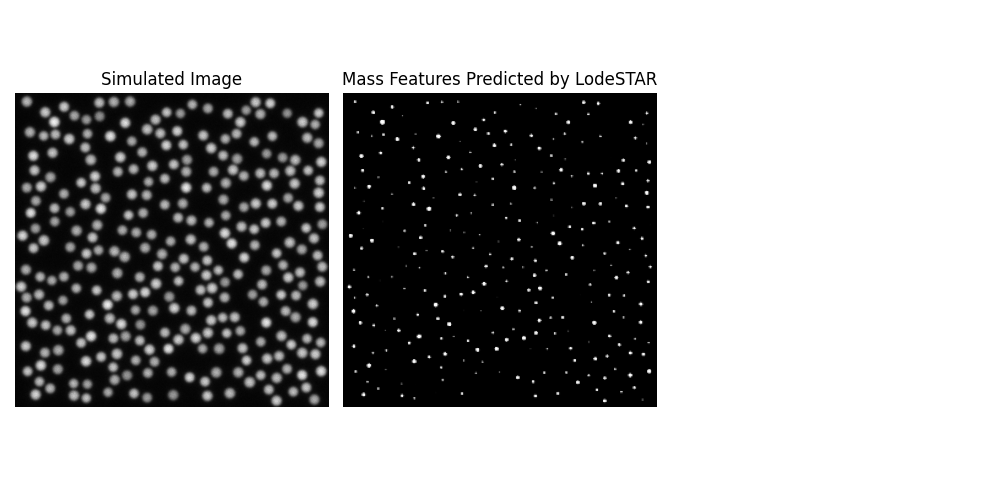

In [85]:
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(simulated_image), cmap="gray")
plt.axis("off")
plt.title("Simulated Image")

#  Subfigure 2, mass feature distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature, cmap="gray")
plt.axis("off")
plt.title("Mass Features Predicted by LodeSTAR")

plt.axis("off")
plt.tight_layout()
plt.show()

Plot the predicted positions from LodeSTAR alongside the ground truth on the simulated image and quantify the performance.

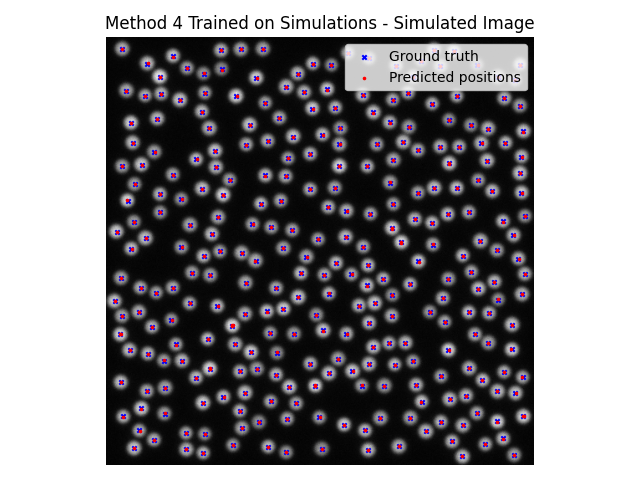

True Positives: 288/288
False Positives: 10
False Negatives: 0
F1 Score: 0.9829
RMSE: 0.4699


In [86]:
# Plot the predicted positions and the ground truth overlaid on the simulated
# image.
utils.plot_predicted_positions(
    image=simulated_image,
    predicted_positions=detections_lodestar,
    ground_truth_positions=gt_pos,
    title="Method 4 Trained on Simulations - Simulated Image",
)
#  Evaluate performance.
utils.evaluate_locs(detections_lodestar, gt_pos, distance_th=particle_radius);

### Apply the Trained LodeSTAR on Experiments

- Apply LodeSTAR to the experimental image using the same inference settings (alpha, beta, cutoff) as before.
- Run the model to extract prediction features, including the mass channel.
- Get the final particle coordinates and print the total number of detections.
- Visualize the original experimental image and the mass feature map predicted by LodeSTAR.

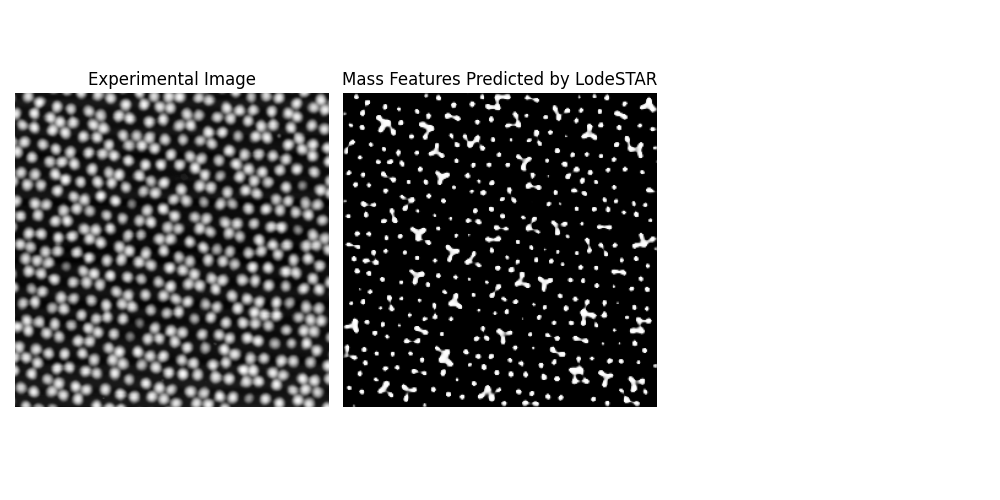

In [87]:
#  Parameters for inference.
alpha = 0.2
beta = 1 - alpha
cutoff = 0.002

#  Extract predictions and convert into a tensor
prediction_exp = lodestar(image_of_particles_exp_tensor).squeeze().detach()

# Extract the mass feature from the prediction
mass_feature_exp = prediction_exp[2]

#  Infer positions from experimental image.
detections_lodestar_experimental = lodestar.detect(
    image_of_particles_exp_tensor,
    alpha = alpha,
    beta = beta, 
    mode = "constant",
    cutoff = cutoff,
)[0]
                         
### Display predictions of experimental image
# Set the figure size
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(image_of_particles_exp), cmap="gray")
plt.axis("off")
plt.title("Experimental Image")

#  Subfigure 2, mass features.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature_exp, cmap="gray")
plt.axis("off")
plt.title("Mass Features Predicted by LodeSTAR")

plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.tight_layout()
plt.show()

Display the experimental image with the predicted particle positions overlaid to visually inspect the detection quality.

No ground truth positions were passed


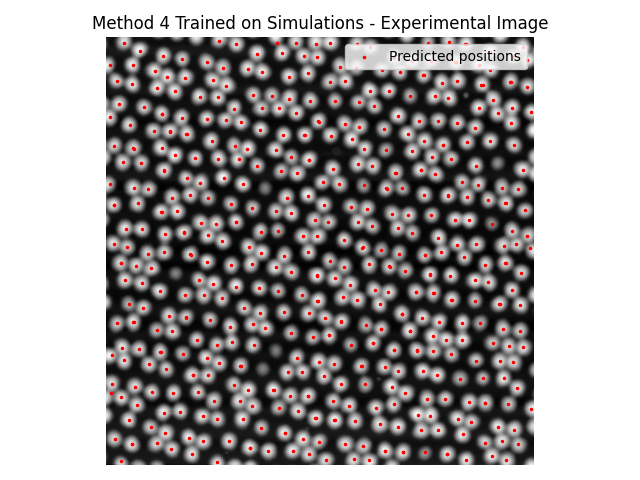

Found 508 detections.


In [88]:
utils.plot_predicted_positions(
   image=image_of_particles_exp[0, 0, :, :],
   predicted_positions= detections_lodestar_experimental,
   title="Method 4 Trained on Simulations - Experimental Image",
)
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")

### Train LodeSTAR with Experiments

Since LodeSTAR is self-supervised, you can train it directly on experimental crops—no ground-truth labels needed.

Start by identifying a few representative particles in the experimental image. From these, extract small crops centered on the particles. These serve as the training data, and LodeSTAR learns by applying random transformations to these crops and predicting how the particle positions change.

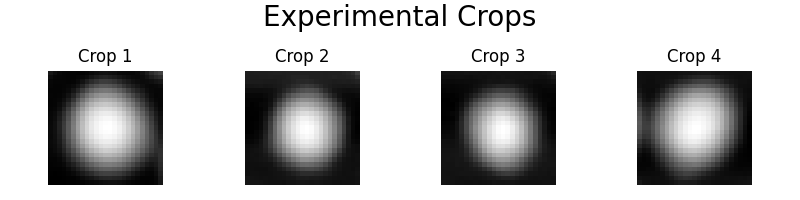

In [ ]:
# Get coordinates from relevant crop samples.
xs = [272, 177, 190, 435]
ys = [230, 168, 362, 330]

number_of_crops = len(xs)

# Pre-allocate array to store all the crops.
training_images = []
for i in range(number_of_crops):
    # Go through the locations of the crops in the image.
    x_index = xs[i]
    y_index = ys[i]
    crop_size = 25

    # Crop a window in the image.
    x0 = x_index
    y0 = y_index
    training_image = np.array(image[y0:y0 + crop_size, x0: x0 + crop_size])

    # Expand dims with np.newaxis and append to list.
    training_images.append(training_image[np.newaxis, ...])

# Plot up to 18 crops.
utils.plot_crops(np.squeeze(training_images), title="Experimental Crops")

Prepare the training pipeline with the selected experimental crops.

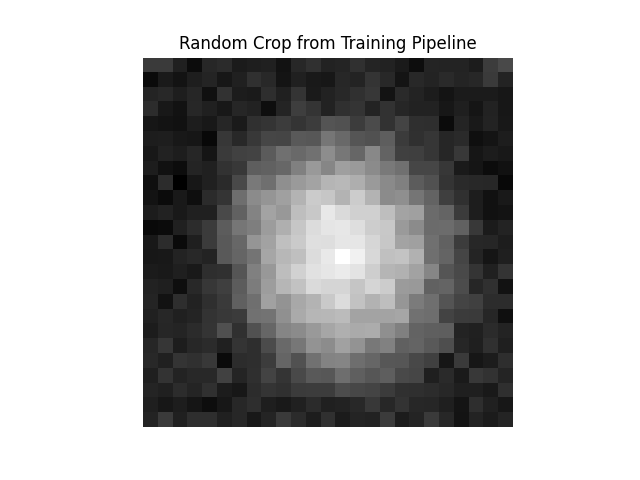

In [90]:
# Random selector of crops.
random_crop = lambda: random.choice(training_images)

# Define training pipeline.
training_pipeline = (
    dt.Value(random_crop)
    >> dt.NormalizeMinMax(0.0, 1.0)
    >> dt.Gaussian(0, 0.05)
    >> dt.NormalizeMinMax(
        lambda: np.random.uniform(0.0, 0.2), 
        lambda: np.random.uniform(0.8, 1.0),
        )
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

# Build a training dataset with a pipeline that randomly selects a crop each
# time.
train_dataset = dt.pytorch.Dataset(
    training_pipeline,
    length=512,
)

# Dataloader contains the randomized training dataset and additional settings.
dataloader = dl.DataLoader(
    train_dataset,
    batch_size=16,
)

# We can check one of the elements in the training pipeline with augmentations.
sanity_check_crop = training_pipeline.update().resolve()
plt.figure()
plt.imshow(np.squeeze(sanity_check_crop), cmap="gray", aspect="equal")
plt.title("Random Crop from Training Pipeline")
plt.axis("off")
plt.show()

Create a LodeSTAR model with 8 random geometric transformations per input and set up the trainer, which will handle the training loop. It runs for 32 epochs.

In [91]:
#  Initialize the model.
lodestar_exp = dl.LodeSTAR(
    n_transforms=8, 
    optimizer=dl.Adam(lr=1e-3),
).build()

# Set up the trainer and specify number of epochs.
trainer_lodestar_exp = dl.Trainer(max_epochs=32, accelerator="auto")

Check if pretrained weights already exist. Otherwise train LodeSTAR on the experimental crops using the training pipeline and save the trained weights for later use. Otherwise, simply load the existing weights from file.

Finally, switch the model to evaluation mode, which disables training-specific behaviors.

In [92]:
# Define whether to force training even if weights exist.
force_training = True

# Define folder and path for storing LodeSTAR experimental weights.
folder_name = "LodeSTAR"
lodestar_exp_path = os.path.join(folder_name, "lodestar_weights_exp")

# Train or load weights.
if not os.path.isfile(lodestar_exp_path) or force_training:
    print("Training LodeSTAR on experimental data (either forced or weights not found).")
    
    # Ensure the save directory exists.
    os.makedirs(folder_name, exist_ok=True)

    # Train the model.
    trainer_lodestar_exp.fit(lodestar_exp, dataloader)

    # Save weights.
    torch.save(lodestar_exp.state_dict(), lodestar_exp_path)
    print(f"Saved experimental LodeSTAR weights to '{lodestar_exp_path}'.")
else:
    # Load pre-trained weights.
    lodestar_exp.load_state_dict(torch.load(lodestar_exp_path, weights_only=True))
    print(f"Loaded preexisting LodeSTAR weights from '{lodestar_exp_path}'.")

# Set model to evaluation mode.
lodestar_exp.eval();


Training LodeSTAR on experimental data (either forced or weights not found).


/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  251 K │ train │
│ 1 │ between_loss  │ L1Loss                     │      0 │ train │
│ 2 │ within_loss   │ L1Loss                     │      0 │ train │
│ 3 │ train_metrics │ MetricCollection           │      0 │ train │
│ 4 │ val_metrics   │ MetricCollection           │      0 │ train │
│ 5 │ test_metrics  │ MetricCollection           │      0 │ train │
│ 6 │ optimizer     │ Adam                       │      0 │ train │
└───┴───────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 251 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 251 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 39                                                                                          
Modules in eval mode: 0

Output()

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Saved experimental LodeSTAR weights to 'LodeSTAR/lodestar_weights_exp'.


Apply the trained LodeSTAR model to an experimental image. Set the inference parameters which control detection sensitivity. Get the prediction features, including the mass_feature, which can be useful for visualizing detections. Extract the final coordinates of the detected particles and print how many particles were detected.

In [105]:
#  Parameters for inference.
alpha = 0.2
beta = 1 - alpha 
cutoff = 0.002
#  Extract predictions and convert into a tensor.
prediction_exp = lodestar_exp(image_of_particles_exp_tensor).squeeze().detach()

# Extract the mass feature from the prediction.
mass_feature_exp = prediction_exp[2]

#  Infer positions from experimental image.
detections_lodestar_experimental = lodestar_exp.detect(
    image_of_particles_exp_tensor,
    alpha=alpha,
    beta=beta, 
    mode="constant",
    cutoff=cutoff,
)[0]
                         
print(f"Found {len(detections_lodestar_experimental[:,1])} detections.")

Found 477 detections.


Display mass features predicted for the experimental image.

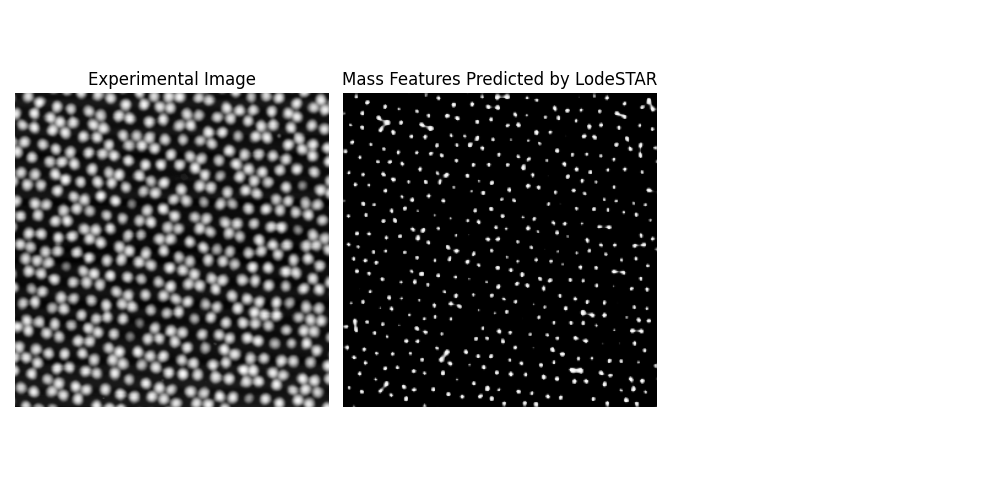

In [106]:
# Set the figure size.
plt.figure(figsize=(10, 5))

#  Subfigure 1, test image.
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(image_of_particles_exp), cmap="gray")
plt.axis("off")
plt.title("Experimental Image")

#  Subfigure 2, mass feature distribution.
plt.subplot(1, 3, 2)
plt.imshow(mass_feature_exp, cmap="gray")
plt.axis("off")
plt.title("Mass Features Predicted by LodeSTAR")

plt.gca().set_aspect('equal', adjustable='box')
plt.axis("off")
plt.tight_layout()
plt.show()

Plot the predicted positions from LodeSTAR on the experimental image.

No ground truth positions were passed


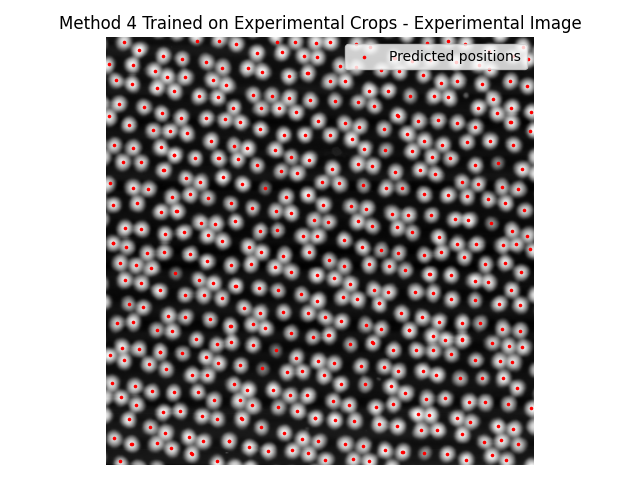

In [107]:
utils.plot_predicted_positions(
   image=image_of_particles_exp[0, 0, :, :],
   predicted_positions= detections_lodestar_experimental,
   title="Method 4 Trained on Experimental Crops - Experimental Image",
)